*08/14/24*
Authors: Ismael Mendoza

In [71]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [72]:
import galsim 
import jax_galsim as xgalsim

In [73]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date
from tqdm import tqdm

In [74]:
from functools import partial

In [75]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [76]:
jax.devices()

[CudaDevice(id=0)]

In [77]:
GPU = jax.devices('gpu')[0]

In [78]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [79]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2}

In [80]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

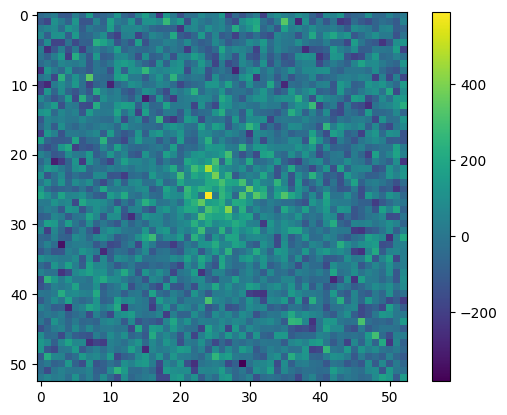

In [81]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0][0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [82]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [83]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

def draw_gal(f, hlr, g1, g2):
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

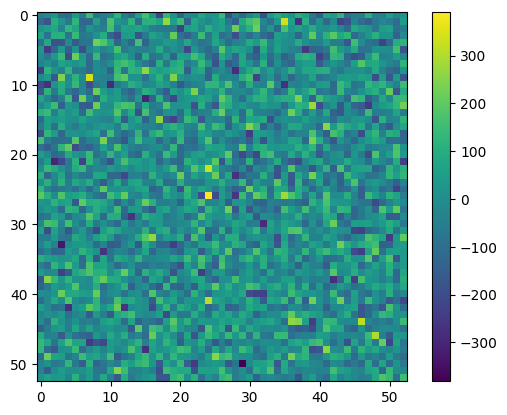

In [84]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

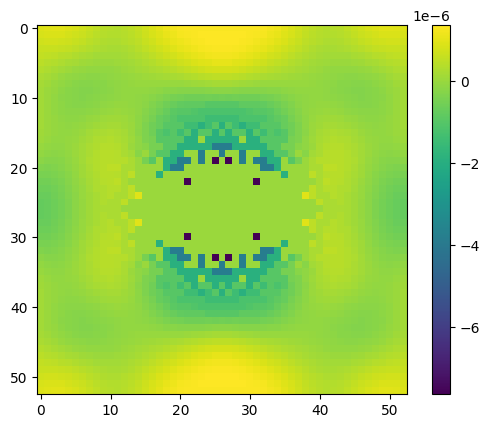

In [85]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [86]:
# timing makes sense
draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS)

%timeit draw_gal_jitted(**TRUE_PARAMS) # ~ twice fast
%timeit _draw_gal()

164 μs ± 6.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
423 μs ± 8.81 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Numpyro example

In [98]:
draw_gal_jitted = jjit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU).shape

(53, 53)

In [119]:
import numpyro.distributions as dist
def prob_model(data):
    lf = numpyro.sample('lf', dist.Uniform(4,6))
    hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
    g1 = numpyro.sample('g1', dist.Uniform(-0.4, 0.4))
    g2 = numpyro.sample('g2', dist.Uniform(-0.4, 0.4))
    im = draw_gal(lf, hlr, g1, g2)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)


In [120]:
from numpyro.infer import MCMC, NUTS

In [121]:
data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
data = jax.device_put(data, device=GPU)
data.devices(), data.shape

({CudaDevice(id=0)}, (53, 53))

In [122]:
nuts_kernel = NUTS(prob_model, max_tree_depth=10)

In [125]:
# %%time ## a little longer but at the same order as warmup in blackjax!
# mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=1, num_chains=1)
# rng_key = random.PRNGKey(43)
# mcmc.run(rng_key, data=data)

sample: 100%|██████████| 201/201 [00:08<00:00, 22.42it/s, 15 steps of size 3.00e-01. acc. prob=0.96] 


CPU times: user 9.54 s, sys: 218 ms, total: 9.76 s
Wall time: 9.62 s


# Blackjax NUTS setup

In [87]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (4., 5.), 'hlr': (0.7, 1.2), 'g1': (-0.1, 0.1), 'g2': (-0.1, 0.1)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [88]:
def transform_func(params):
    """Every variable is assumed to be uniform between (0,1)"""
    new = {} 
    for p in params:
        new[p] = params[p] * + BOUNDS_GPU[p][0]
    return new

def inv_transform_func(params):
    """Every variable is assumed to be uniform between (0,1)"""
    new = {} 
    for p in params:
        new[p] = (params[p] - BOUNDS_GPU[p][0]) / (BOUNDS_GPU[p][1] - BOUNDS_GPU[p][0]) 
    return new

def _logprob_fn(params, data):
    f = params['f']
    hlr = params['hlr']
    g1 = params['g1'] 
    g2 = params['g2'] 
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

def _logprob_fn_transform(std_params, data):
    params = transform_func(std_params)
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        prior += stats.uniform.logpdf(std_params[p], 0, 1)

             
    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

In [ ]:
f

# Blackjax vanilla single chain

## Timing separate parts of a single chain

In [126]:
data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
data_gpu = jax.device_put(data, device=GPU)
data_gpu.devices(), type(data_gpu), data_gpu.shape

({CudaDevice(id=0)}, jaxlib.xla_extension.ArrayImpl, (53, 53))

In [127]:
# trick that allows for data to be vmapped later
logdensity = jjit(partial(logdensity_fn, data=data_gpu)) # jitting? 

In [128]:
rng_key = jax.device_put(jax.random.key(44), device=GPU)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [129]:
# initial positions
initial_position = {**TRUE_PARAMS_GPU}

In [53]:
with jax.transfer_guard('log'):
    logdensity(initial_position) # no transfer guard issue here
    jax.value_and_grad(logdensity)(initial_position) ### not sure how to avoid transfer in this case

2024-08-15 11:23:40.044157: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.044800: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.044993: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045299: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045442: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045559: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045673: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11

In [130]:
# # adaptation time as a function fo n_steps
# ts = [] 
# for n_steps in tqdm(range(1, 1001, 100)):
#     t1 = time.time()
#     warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
#     (state, parameters), adapt_info = warmup.run(warmup_key, initial_position, num_steps=n_steps)
#     _ = state.position['f'].block_until_ready()
#     t2 = time.time()
#     ts.append(t2-t1)



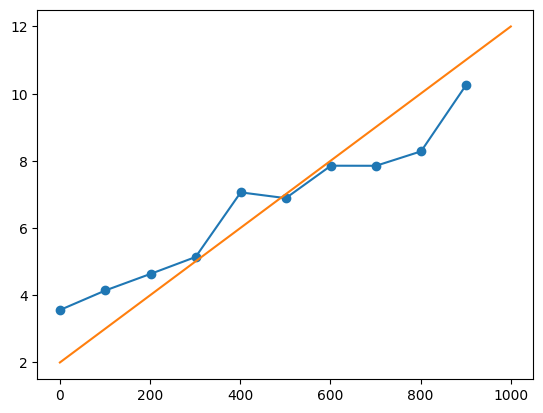

In [27]:
plt.plot(range(1, 1001, 100), ts, '-o')
plt.plot([0, 1000], [2, 12])

In [131]:
# adaptation
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
(state, parameters), adapt_info = warmup.run(warmup_key, initial_position, num_steps=500,)
parameters

{'step_size': Array(0.30582101, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([[ 1.11263019e-03,  1.56222185e-04,  4.11843818e-04,
          1.29039828e-03],
        [ 1.56222185e-04,  2.51591633e-03,  4.37627881e-04,
          7.77552809e-04],
        [ 4.11843818e-04,  4.37627881e-04,  2.81425553e-03,
         -5.50730656e-06],
        [ 1.29039828e-03,  7.77552809e-04, -5.50730656e-06,
          4.63714703e-03]], dtype=float64)}

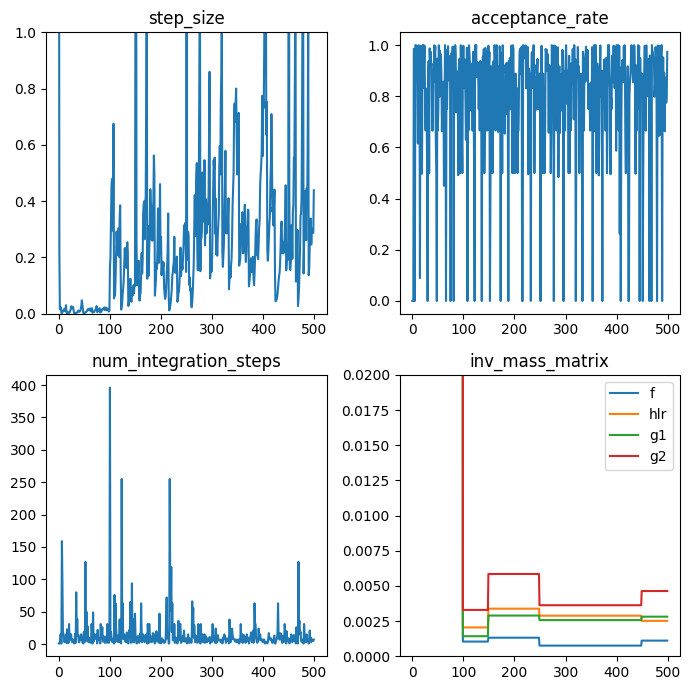

In [132]:
fig, axs = plt.subplots(2,2, figsize=(7,7))
(ax1, ax2, ax3, ax4) = axs.ravel()
ax1.plot(adapt_info.adaptation_state.step_size)
ax1.set_title('step_size')
ax1.set_ylim(0, 1.0)

ax2.plot(adapt_info.info.acceptance_rate)
ax2.set_title('acceptance_rate')


ax3.plot(adapt_info.info.num_integration_steps)
ax3.set_title('num_integration_steps')

# inverse matrix
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 0, 0], label='f')
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 1, 1], label='hlr')
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 2, 2], label='g1')
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 3, 3], label='g2')
ax4.set_ylim(0.0, 0.02)
ax4.legend()

ax4.set_title('inv_mass_matrix')

plt.tight_layout()

In [133]:
kernel = jjit(blackjax.nuts(logdensity, **parameters).step) # not jitted by default

In [294]:
# adaptation time as a function fo n_steps
ts = [] 
for n_samples in tqdm(range(1, 1001, 100)):
    t1 = time.time()
    states = inference_loop(sample_key, kernel, state, n_samples=n_samples)
    _ = states.position['f'].block_until_ready()
    t2 = time.time()
    ts.append(t2-t1)




100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


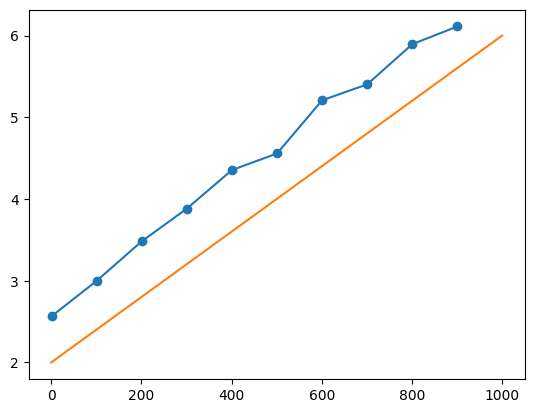

In [296]:
plt.plot(range(1, 1001, 100), ts, '-o')
plt.plot([0, 1000], [2, 6])

In [134]:
%%time
# now run to get actual samples
states = inference_loop(sample_key, kernel, state, n_samples=1000)

CPU times: user 7.39 s, sys: 93.2 ms, total: 7.49 s
Wall time: 7.39 s


In [135]:
samples = states.position

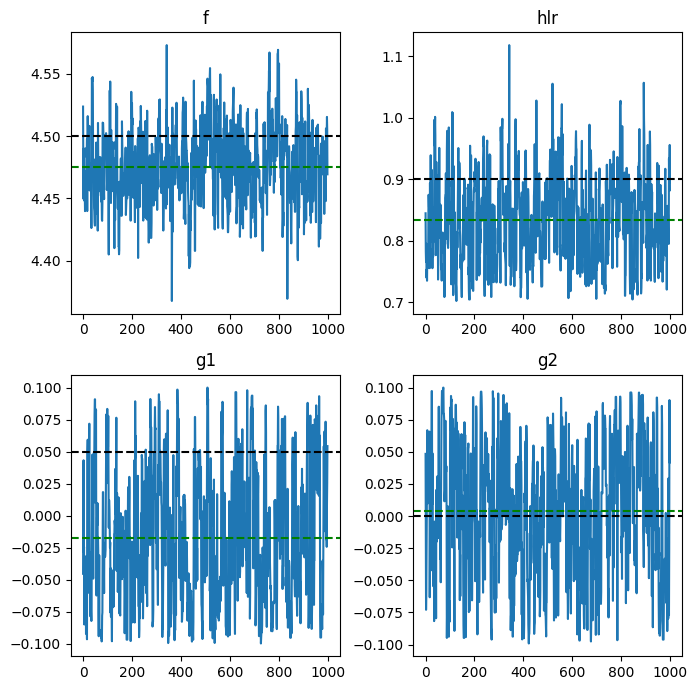

In [136]:
fig, axs = plt.subplots(2,2, figsize=(7,7))
(ax1, ax2, ax3, ax4) = axs.ravel()
ax1.plot(samples['f'])
ax1.set_title('f')
ax1.axhline(TRUE_PARAMS['f'], color='k', linestyle='--')
ax1.axhline(samples['f'].mean(), color='g', linestyle='--')

ax2.plot(samples['hlr'])
ax2.set_title('hlr')
ax2.axhline(TRUE_PARAMS['hlr'], color='k', linestyle='--')
ax2.axhline(samples['hlr'].mean(), color='g', linestyle='--')

ax3.plot(samples['g1'])
ax3.set_title('g1')
ax3.axhline(TRUE_PARAMS['g1'], color='k', linestyle='--')
ax3.axhline(samples['g1'].mean(), color='g', linestyle='--')


ax4.plot(samples['g2'])
ax4.set_title('g2')
ax4.axhline(TRUE_PARAMS['g2'], color='k', linestyle='--')
ax4.axhline(samples['g2'].mean(), color='g', linestyle='--')

plt.tight_layout()

## Time entire thing on different noise realizations

Also interesting to average over different seeds and noise realizations

In [ ]:
run_one_chain = partial(_run_one_chain_timing, logdensity_fn=logdensity_fn, n_warmup=300, n_samples=1000)

In [34]:
# run 10 chains
samples = [] 
warmup_times = [] 
run_times = [] 
for ii in tqdm(range(10)):
    data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
    data_gpu = jax.device_put(data, device=GPU)
    rng_key = jax.device_put(jax.random.key(ii), device=GPU)
    s, wt, rt = run_one_chain(rng_key, data_gpu)
    
    samples.append(s)
    warmup_times.append(wt)
    run_times.append(rt)
    


100%|██████████| 10/10 [02:53<00:00, 17.39s/it]


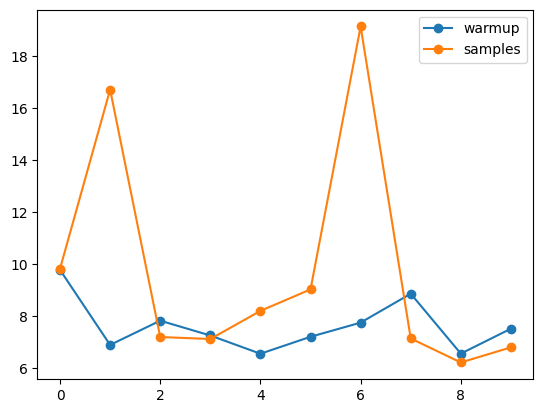

In [36]:
plt.plot(warmup_times, '-o', label='warmup')
plt.plot(run_times, '-o', label='samples')
plt.legend()

In [37]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [43]:
chains = {} 
for p in samples[0].keys():
    chains[p] = jnp.concatenate([s[p].reshape(1, 1000) for s in samples])

In [45]:
chains['f'].shape, chains['g1'].shape

((10, 1000), (10, 1000))

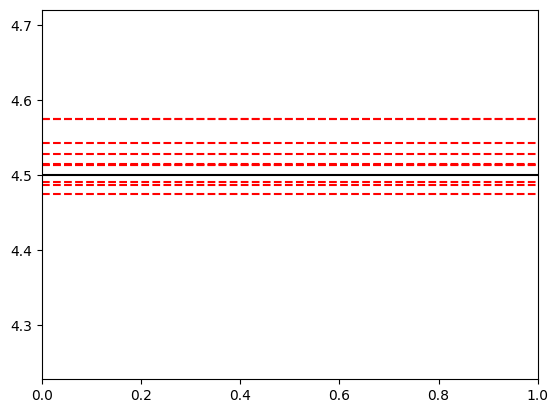

In [47]:
for ii in range(10):
    plt.axhline(chains['f'][ii].mean(), linestyle='--', color='r')
plt.axhline(TRUE_PARAMS['f'], linestyle='-', color='k')

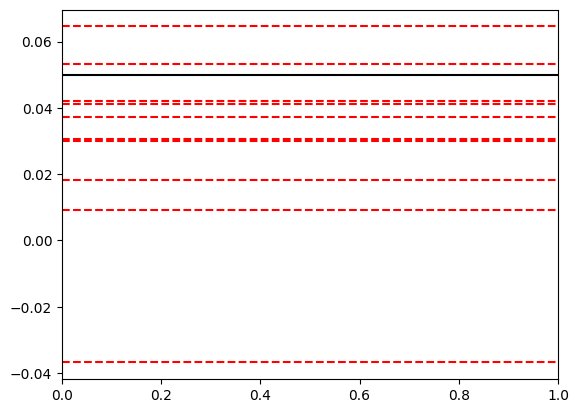

In [52]:
for ii in range(10):
    plt.axhline(chains['g1'][ii].mean(), linestyle='--', color='r')
plt.axhline(TRUE_PARAMS['g1'], linestyle='-', color='k')

## Run multilpe chains on same noise realization to check diagnostics

In [20]:
run_one_chain = partial(_run_one_chain_timing, logdensity_fn=logdensity_fn, n_warmup=300, n_samples=1000)

In [55]:
# run 10 chains
samples = [] 
warmup_times = [] 
run_times = [] 

data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
data_gpu = jax.device_put(data, device=GPU)
for ii in tqdm(range(10)):
    rng_key = jax.device_put(jax.random.key(ii), device=GPU)
    s, wt, rt = run_one_chain(rng_key, data_gpu)
    
    samples.append(s)
    warmup_times.append(wt)
    run_times.append(rt)
    


100%|██████████| 10/10 [02:48<00:00, 16.80s/it]


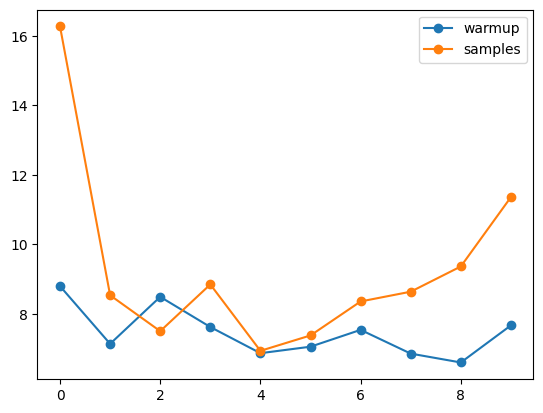

In [77]:
plt.plot(warmup_times, '-o', label='warmup')
plt.plot(run_times, '-o', label='samples')
plt.legend()

In [56]:
chains = {} 
for p in samples[0].keys():
    chains[p] = jnp.concatenate([s[p].reshape(1, 1000) for s in samples])

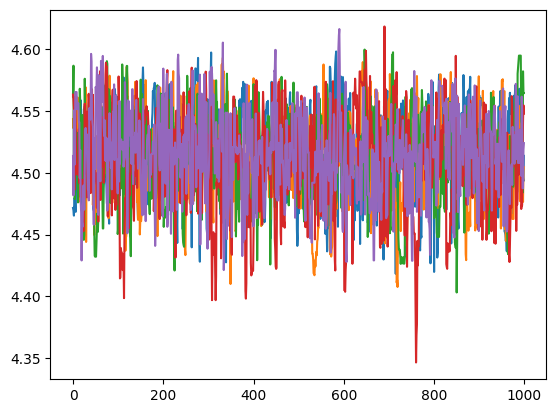

In [60]:
# target same noise realization
for ii in range(5):
    plt.plot(chains['f'][ii]) # very similar

In [61]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [68]:
print('ess')
print()
for p in chains: 
    print(p, effective_sample_size(chains[p], chain_axis=0 ,sample_axis=1))
    
print()
print('r-hat')
print()
for p in chains: 
    print(p, potential_scale_reduction(chains[p], chain_axis=0 ,sample_axis=1))

ess

f 2102.3391618606033
g1 1623.9272897298108
g2 1353.436155234773
hlr 1843.858324649199

r-hat

f 1.0023171014745915
g1 1.0039532315679514
g2 1.0085197889936903
hlr 1.0018364475747452


In [72]:
arviz.ess(np.array(chains['g1'])) # close enough to arviz

1602.5690474192818

# Blackjax vmap kernel and do 1 warmup, same noise image

Successfully parallelizes after the warmup

In [51]:
data, _ = add_noise(_draw_gal(), BACKGROUND, n=1)
data_gpu = jax.device_put(data[0], device=GPU)
rng_key = jax.device_put(jax.random.key(42), device=GPU)

In [52]:
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

# trick that allows for data to be vmapped later
logdensity = jjit(partial(logdensity_fn, data=data_gpu))

# initial positions
initial_position = {**TRUE_PARAMS_GPU}

In [71]:
%%time
# adaptation
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=500)

CPU times: user 5.89 s, sys: 130 ms, total: 6.02 s
Wall time: 5.85 s


In [72]:
parameters

{'step_size': Array(0.37546937, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([[ 0.0010876 ,  0.00046533, -0.00025233,  0.0018068 ],
        [ 0.00046533,  0.00258864, -0.00026454,  0.00171718],
        [-0.00025233, -0.00026454,  0.00210101,  0.00016433],
        [ 0.0018068 ,  0.00171718,  0.00016433,  0.00707494]],      dtype=float64)}

In [73]:
# initailize with adaptatino parameters
nuts = blackjax.nuts(logdensity, parameters['step_size'], parameters['inverse_mass_matrix'])

In [74]:
n_chains = 10
initial_positions = {p:q*jnp.ones((n_chains,)) for p,q in TRUE_PARAMS_GPU.items()}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

In [75]:
%%time ### really fast even with n_chains large
rng_key, sample_key = jax.random.split(rng_key)
kernel = jjit(nuts.step)
states = inference_loop_multiple_chains(
    sample_key, kernel, initial_states, n_samples=1000, n_chains=n_chains
)
_ = states.position["f"].block_until_ready()


CPU times: user 13.8 s, sys: 146 ms, total: 14 s
Wall time: 12.3 s


In [76]:
samples = states.position
samples['f'].shape

(1000, 10)

4.534007269492835
4.535290012788295
4.534682482357403
4.534600491691963
4.53558531679937
4.5337847401752045
4.5356974987740974
4.5340351098968865
4.533873002787504
4.5316148443404725


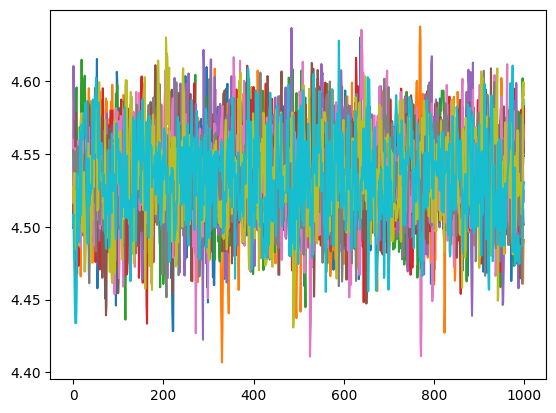

In [77]:
for ii in range(10):
    plt.plot(samples['f'][:, ii])
    print(samples['f'][:,ii].mean())

In [81]:
ess =effective_sample_size(samples['f'], chain_axis=1, sample_axis=0)
ess, ess / samples['f'].size

(Array(2973.14086122, dtype=float64), Array(0.29731409, dtype=float64))

In [82]:
ess =effective_sample_size(samples['g1'], chain_axis=1, sample_axis=0)
ess, ess / samples['g1'].size

(Array(1842.71613283, dtype=float64), Array(0.18427161, dtype=float64))

In [80]:
potential_scale_reduction(samples['f'], chain_axis=1, sample_axis=0), potential_scale_reduction(samples['g1'], chain_axis=1, sample_axis=0)

(Array(1.00024706, dtype=float64), Array(1.00138824, dtype=float64))

# Blackjax transformed single chain

In [45]:
data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
data_gpu = jax.device_put(data, device=GPU)
data_gpu.devices(), type(data_gpu), data_gpu.shape

({CudaDevice(id=0)}, jaxlib.xla_extension.ArrayImpl, (53, 53))

In [46]:
# trick that allows for data to be vmapped later
logdensity = jjit(partial(logdensity_fn_transform, data=data_gpu)) # jitting? 

In [89]:
# make sure logdensity_fn_trans is as fast as jitted draw_gal
%timeit logdensity(inv_transform_func(TRUE_PARAMS_GPU))

458 μs ± 7.45 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
rng_key = jax.device_put(jax.random.key(42), device=GPU)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [48]:
# initial positions
initial_position = inv_transform_func(TRUE_PARAMS_GPU)
initial_position

{'f': Array(0.5, dtype=float64, weak_type=True),
 'g1': Array(0.75, dtype=float64, weak_type=True),
 'g2': Array(0.5, dtype=float64, weak_type=True),
 'hlr': Array(0.4, dtype=float64, weak_type=True)}

In [54]:
%%time
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
(state, parameters), adapt_info = warmup.run(warmup_key, initial_position, num_steps=300,)
parameters

CPU times: user 5.06 s, sys: 70.4 ms, total: 5.13 s
Wall time: 5.09 s


{'step_size': Array(0.02650693, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([[ 4.82448873e-05,  1.09250725e-07, -3.91506747e-07,
         -5.50926534e-07],
        [ 1.09250725e-07,  5.22520947e-05,  1.06277723e-06,
          2.65643532e-06],
        [-3.91506747e-07,  1.06277723e-06,  4.97491943e-05,
         -2.06836017e-06],
        [-5.50926534e-07,  2.65643532e-06, -2.06836017e-06,
          7.28627811e-05]], dtype=float64)}

In [61]:
state.position

{'f': Array(0.99875796, dtype=float64, weak_type=True),
 'g1': Array(0.85828582, dtype=float64, weak_type=True),
 'g2': Array(0.63310789, dtype=float64, weak_type=True),
 'hlr': Array(0.25272107, dtype=float64, weak_type=True)}


# Blackjax vmap

In [21]:
run_one_chain = partial(_run_one_chain, logdensity_fn=logdensity_fn, n_warmup=300, n_samples=1000)
run_multiple_chains = jax.vmap(run_one_chain)

In [22]:
# timing of running multilpe chains as function of chains
all_samples = [] 
times = [] 
for n_chains in (1, 3, 5, 10, 20, 40):
    print('n_chains:', n_chains)
    data, _ = add_noise(_draw_gal(), BACKGROUND, n=n_chains)
    data_gpu = jax.device_put(data, device=GPU)
    rng_key = jax.device_put(jax.random.key(n_chains), device=GPU)
    keys = jax.random.split(rng_key, n_chains)
    t1 = time.time()
    samples = run_multiple_chains(keys, data_gpu)
    _ = samples['f'].block_until_ready()
    t2 = time.time()
    times.append(t2 - t1)
    all_samples.append(samples)


n_chains: 1
n_chains: 3
n_chains: 5
n_chains: 10
n_chains: 20
n_chains: 40


In [27]:
times

[38.2419171333313,
 24.628092288970947,
 26.204280614852905,
 58.35218691825867,
 163.89156985282898,
 253.2425320148468]

Text(0, 0.5, 'times (s)')

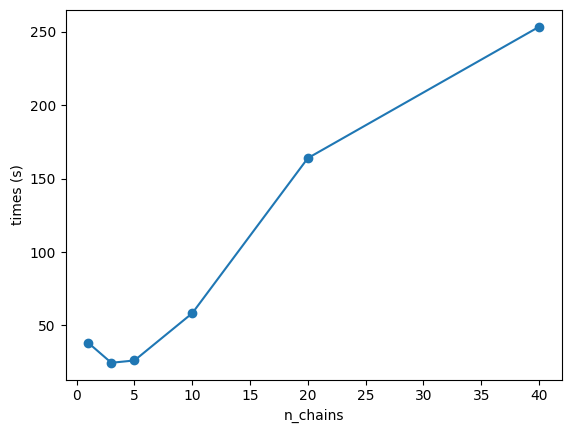

In [26]:
#hmm uncertainty, one bad run sometimes 

plt.plot([1,3, 5,10,20,40], times, '-o')
plt.xlabel('n_chains')
plt.ylabel('times (s)')

# Blackjax vmap warmup, then vmap inference

In [70]:
N_CHAINS = 10

In [67]:
rng_key = jax.device_put(random.key(43), device=GPU)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
warmup_key.devices()

{CudaDevice(id=0)}

In [68]:
data, _ = add_noise(_draw_gal(), BACKGROUND, n=N_CHAINS) #n_chains
data_gpu = jax.device_put(data, device=GPU)
data_gpu.shape, data_gpu.devices()

((10, 53, 53), {CudaDevice(id=0)})

In [69]:
init_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
init_positions['f'].devices()

{CudaDevice(id=0)}

In [44]:
warmup_seeds = jax.random.split(warmup_key, N_CHAINS)
do_warmup = jax.vmap(partial(_run_warmup, n_steps=1000, logdensity_fn=logdensity_fn))

In [45]:
%%time
states, tuned_params, adapt_infos = do_warmup(warmup_seeds, data_gpu, init_positions)

CPU times: user 20.8 s, sys: 0 ns, total: 20.8 s
Wall time: 20 s


In [46]:
adapt_infos.info.is_divergent.sum(axis=-1) # need to investigate and or avoid divergences?

Array([268, 249, 267, 245, 265, 269, 240, 257, 260, 265], dtype=int64)

In [47]:
tuned_params['step_size'].shape, tuned_params['inverse_mass_matrix'].shape

((10,), (10, 4))

In [48]:
tuned_params['step_size'] # all over the place?

Array([0.05582932, 0.18130817, 0.02098437, 0.15859425, 0.26489313,
       0.13495419, 0.29713571, 0.30785699, 0.16841492, 0.10908763],      dtype=float64, weak_type=True)

In [49]:
tuned_params['inverse_mass_matrix'][:, 1] # same? 

Array([0.00212245, 0.00241037, 0.00148438, 0.00211313, 0.000742  ,
       0.00189993, 0.00173803, 0.00141745, 0.00182657, 0.00129793],      dtype=float64)

In [50]:
%%time
# now run vmap inference_loop
states, infos = inference_loop_multiple_chains(sample_key, states, tuned_params, data_gpu, logdensity_fn, 
                                               n_samples=1000, n_chains=N_CHAINS)

CPU times: user 51.5 s, sys: 75 ms, total: 51.6 s
Wall time: 50.7 s


In [51]:
samples = states.position

In [52]:
samples['f'].shape

(1000, 10)

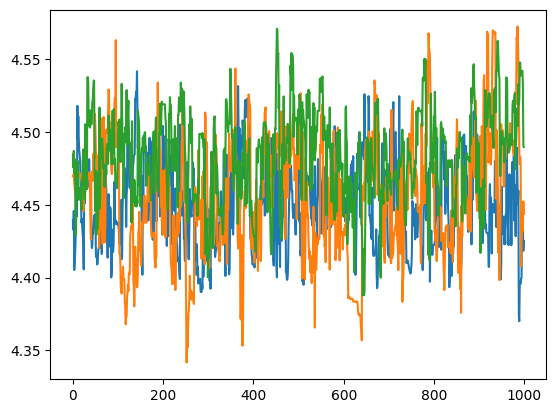

In [54]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 2])
plt.plot(samples['f'][:, 8])

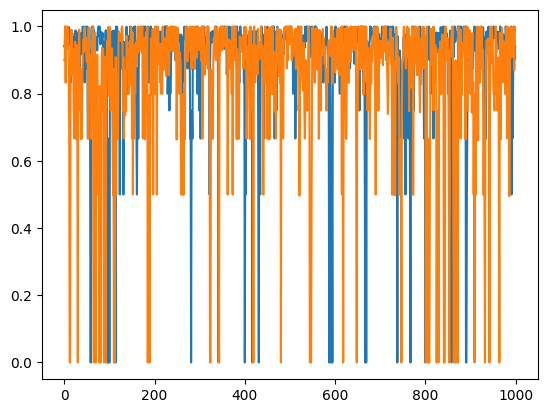

In [57]:
plt.plot(infos.acceptance_rate[:, 0])
plt.plot(infos.acceptance_rate[:, 5])

In [59]:
infos.is_divergent.sum(axis=0)

Array([866, 764, 849, 747, 789, 799, 802, 810, 888, 865], dtype=int64)

(array([1599., 2228., 1402., 1753.,  559.,  420.,  307.,  570.,  106.,
          86.,   79.,   62.,   56.,   56.,   33.,  158.,   27.,   23.,
          36.,   27.,   32.,   29.,   18.,   19.,   18.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100.]),
 <BarContainer object of 25 artists>)

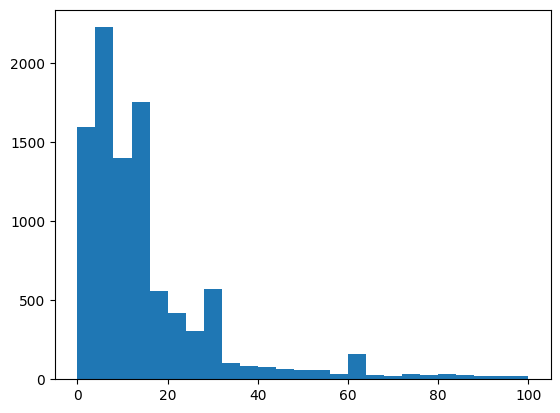

In [64]:
plt.hist(infos.num_integration_steps.ravel(), bins=25, range=(0, 100))

## What if we average the step sizes and mass matrix from warmup?